In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os 
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

In [3]:
# Load model directly
from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
model = AutoModel.from_pretrained("facebook/dinov2-large")

/Users/danatal/tools/miniconda3/envs/ldm310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Load image frim directory: 

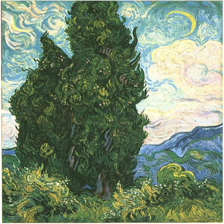

In [4]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
import torch
import numpy as np
from pathlib import Path



def load_image(path, size=224):
    path = Path(path)
    img = Image.open(path).convert("RGB").resize((size, size))
    x = torch.from_numpy((np.array(img).astype("float32") / 255.0)).permute(2,0,1)  # [3,H,W] in [0,1]
    return img, x.unsqueeze(0)  # PIL, [1,3,H,W]

path1 = f"../pics/im1.jpg"
path2 = f"../pics/im2.jpg"
path3 = f"../pics/im3.jpg"


im1, t1 =load_image(path1)
im2, t2 =load_image(path2)
im3, t3 =load_image(path3)

type(im1)
im2

In [5]:
inputs = processor(images=[im1, im2, im3], return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state  # shape: [batch, tokens, feature_per_token]
patch_tokens = last_hidden_states[:, 1:, :] 


In [6]:
import torch.nn.functional as F
# gram function to extract style
def gram_from_tokens(tokens):
    #\"\"\"tokens: [B, N, C] -> Gram feature [B, C*C]\"\"\"
    B, N, C = tokens.shape
    X = tokens / (N ** 0.5)
    G = torch.bmm(X.transpose(1, 2), X)       # [B, C, C]
    return G.reshape(B, C * C)

def cosine_sim(a, b):
    # a,b: [B, D]
    a = F.normalize(a, dim=1)
    b = F.normalize(b, dim=1)
    return (a * b).sum(dim=1)

style_vec = gram_from_tokens(patch_tokens)
cos_res = cosine_sim(style_vec[0].unsqueeze(0), style_vec[1].unsqueeze(0)).item()


## Load wiki art dataset


In [7]:
from datasets import load_dataset

dataset = load_dataset("huggan/wikiart", "default")  # or "style"
image = dataset["train"][0]["image"]  # PIL image
image.show()

Number of styles: 27


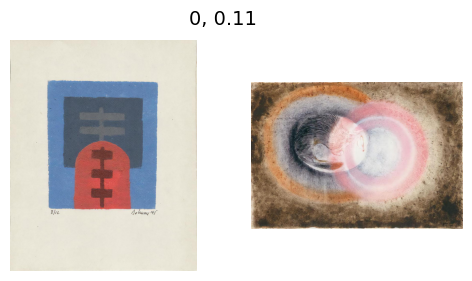

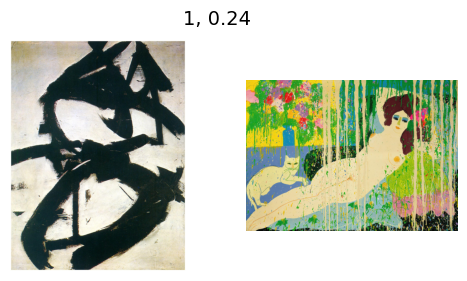

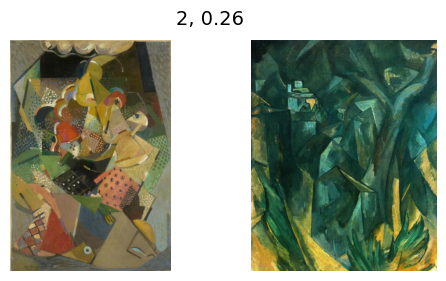

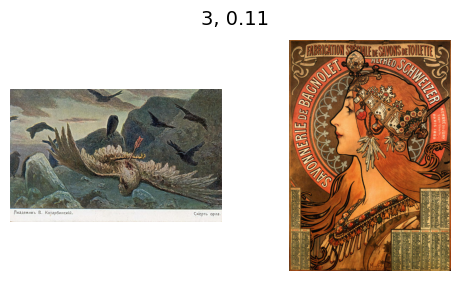

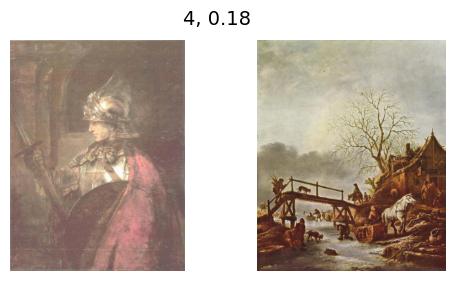

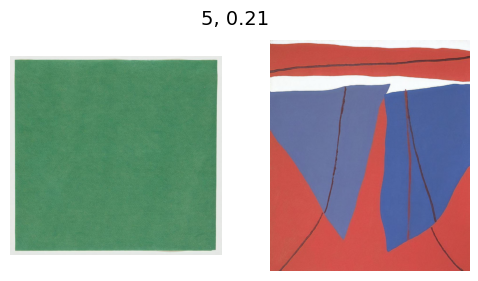

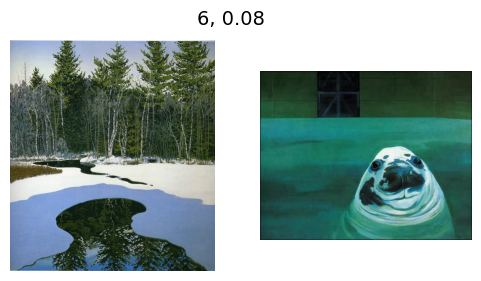

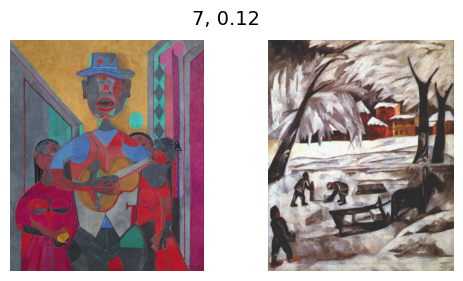

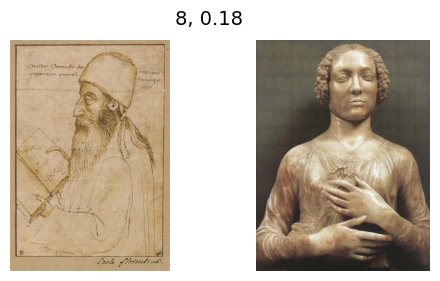

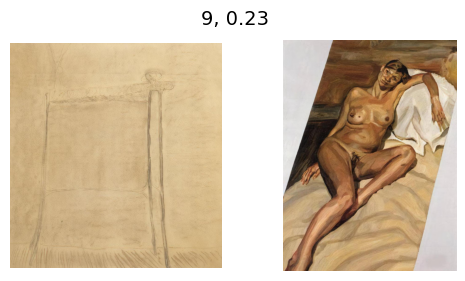

In [8]:

import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Load the dataset
train = dataset["train"]


# Build a dict: style -> list of indices
style_to_indices = defaultdict(list)
for idx, style in enumerate(train["style"]):
    style_to_indices[style].append(idx)

styles = sorted(style_to_indices.keys())
print(f"Number of styles: {len(styles)}")

# Show 2 images per style (first 10 styles for demo)
for style in styles[:10]:
    idxs = random.sample(style_to_indices[style], 2)
    samples = [train[i] for i in idxs]

    # get style from dinov2
    inputs = processor(images=[samples[0]['image'], samples[1]['image']], return_tensors="pt")
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state  # shape: [batch, tokens, feature_per_token]
    patch_tokens = last_hidden_states[:, 1:, :] 
    style_vec = gram_from_tokens(patch_tokens)
    cos_res = cosine_sim(style_vec[0].unsqueeze(0), style_vec[1].unsqueeze(0)).item()   
    
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"{style}, {cos_res:.2f}", fontsize=14)
    for ax, sample in zip(axes, samples):
        ax.imshow(sample["image"])
        #ax.set_title(f"{sample['genre']}, {sample['artist']}")
        ax.axis("off")
    plt.show()


## more sofisticated method

In [10]:


import torch, torch.nn.functional as F
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available()
         else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
         else "cpu")
# Load HF DINOv2
#model_id = "facebook/dinov2-base"   # other options: -large, -giant (heavier)
#processor = AutoImageProcessor.from_pretrained(model_id)
#model = Dinov2Model.from_pretrained(model_id).eval().to(device)
model = model.eval().to(device)

def gram(tokens, offdiag_only=True):
    # tokens: [B, N, C]
    B, N, C = tokens.shape
    X = tokens / (N ** 0.5)
    G = X.transpose(1, 2) @ X     # [B, C, C]
    if offdiag_only:
        G = G - torch.diag_embed(torch.diagonal(G, dim1=1, dim2=2))
    return G.reshape(B, -1)       # [B, C*C]

def adain(tokens):
    mu  = tokens.mean(dim=1)
    std = tokens.std(dim=1) + 1e-6
    return torch.cat([mu, std], dim=1)

def style_vec(pil_img, layers=(-4, -2, -1), use_adain=False):
    """
    pil_img -> normalized style vector from multiple hidden states.
    `layers` are indices into hidden_states (negative = from the end).
    """
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True)
    hs_list = [out.hidden_states[i] for i in layers]   # each: [B, N+1, C]
    parts = []
    for hs in hs_list:
        tok = hs[:, 1:, :]                             # drop CLS
        part = adain(tok) if use_adain else gram(tok, offdiag_only=True)
        parts.append(part)
    v = torch.cat(parts, dim=1)
    return F.normalize(v, dim=1)                       # cosine‑ready

def cosine(a, b):
    return (a * b).sum(dim=1).item()

# # Example
# img1 = Image.open("image1.jpg").convert("RGB")
# img2 = Image.open("image2.jpg").convert("RGB")

s1 = style_vec(im1, layers=(-4, -2, -1), use_adain=False)  # Gram, multi-layer
s2 = style_vec(im2, layers=(-4, -2, -1), use_adain=False)

print("cosine similarity:", cosine(s1, s2))


cosine similarity: 0.6600381135940552


In [12]:
import torch, torch.nn.functional as F
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image

# --- setup ---
device = torch.device("cuda" if torch.cuda.is_available()
         else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
         else "cpu")

model_id  = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_id)
model     = Dinov2Model.from_pretrained(model_id).eval().to(device)

# Pillow compatibility (newer Pillow uses Image.Resampling.*)
try:
    _BILINEAR = Image.Resampling.BILINEAR
except AttributeError:
    _BILINEAR = Image.BILINEAR

def gram(tokens, offdiag_only=True):
    # tokens: [B, N, C]
    B, N, C = tokens.shape
    X = tokens / (N ** 0.5)
    G = X.transpose(1, 2) @ X     # [B, C, C]
    if offdiag_only:
        G = G - torch.diag_embed(torch.diagonal(G, dim1=1, dim2=2))
    return G.reshape(B, -1)

def adain(tokens):
    mu  = tokens.mean(dim=1)
    std = tokens.std(dim=1) + 1e-6
    return torch.cat([mu, std], dim=1)

def _expected_size():
    # Prefer model.config.image_size, otherwise fall back to processor size
    sz = getattr(model.config, "image_size", None)
    if isinstance(sz, int):
        return sz, sz
    # processor.size can be int or dict; handle common cases
    ps = getattr(processor, "size", None)
    if isinstance(ps, int):
        return ps, ps
    if isinstance(ps, dict):
        if "height" in ps and "width" in ps:
            return ps["height"], ps["width"]
        if "shortest_edge" in ps:
            return ps["shortest_edge"], ps["shortest_edge"]
    # safe default for dinov2-base
    return 224, 224

def style_vec_mps_safe(pil_img, layers=(-4, -2, -1), use_adain=False):
    """
    Resize on CPU with PIL (bilinear) to the model's expected size,
    then run DINOv2 with output_hidden_states=True and build a style vector.
    """
    H, W = _expected_size()
    # CPU resize (PIL) -> no PyTorch bicubic on MPS
    pil_fixed = pil_img.resize((W, H), _BILINEAR)

    # Disable processor resize/crop to avoid hidden interpolate ops
    inputs = processor(
        images=pil_fixed,
        return_tensors="pt",
        do_resize=False,
        do_center_crop=False
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True)

    # Collect selected hidden states and build style vector
    parts = []
    for li in layers:
        hs = out.hidden_states[li]      # [B, N+1, C]
        tok = hs[:, 1:, :]              # drop CLS
        part = adain(tok) if use_adain else gram(tok, offdiag_only=True)
        parts.append(part)
    v = torch.cat(parts, dim=1)
    return F.normalize(v, dim=1)

def cosine(a, b):
    return (a * b).sum(dim=1).item()


In [13]:
from PIL import Image

s1 = style_vec_mps_safe(im1, layers=(-4, -2, -1), use_adain=False)
s2 = style_vec_mps_safe(im2, layers=(-4, -2, -1), use_adain=False)
print("cosine:", cosine(s1, s2))


cosine: 0.7000628113746643


Number of styles: 27


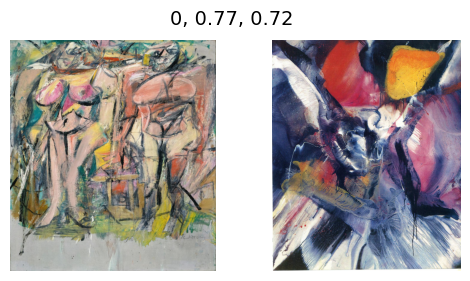

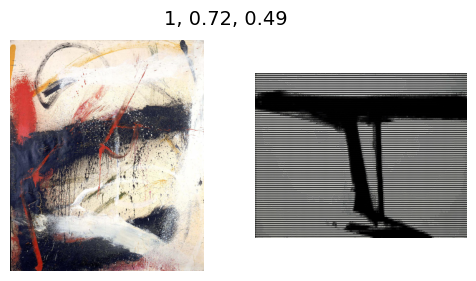

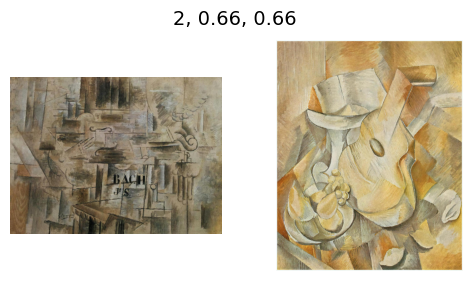

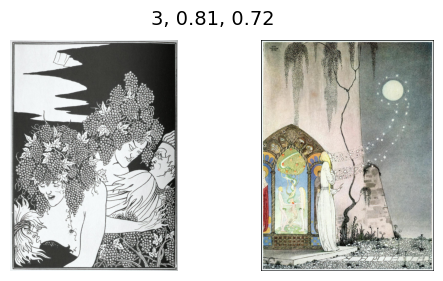

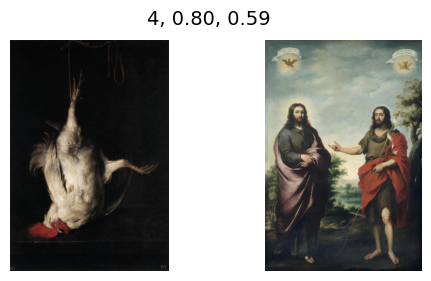

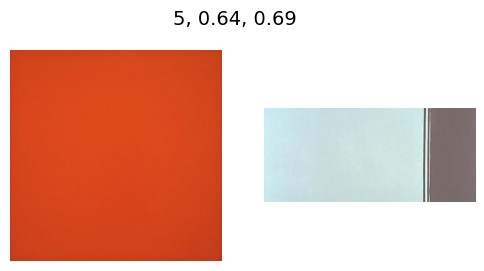

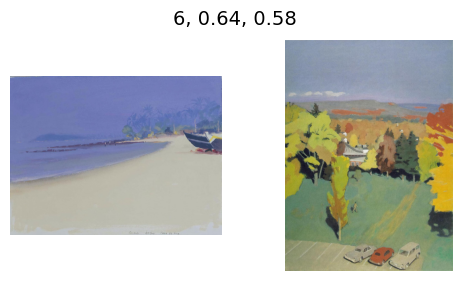

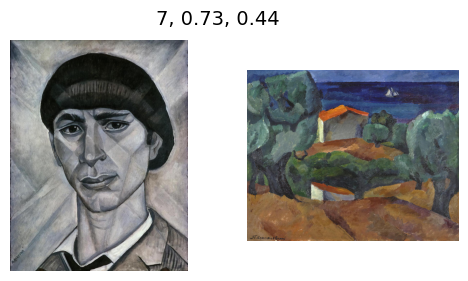

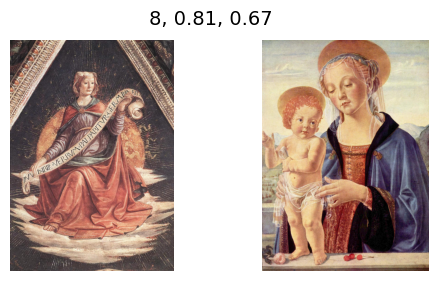

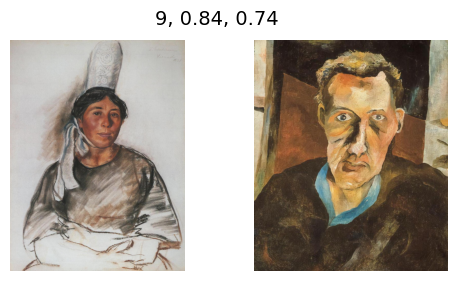

In [14]:

import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Load the dataset
train = dataset["train"]


# Build a dict: style -> list of indices
style_to_indices = defaultdict(list)
for idx, style in enumerate(train["style"]):
    style_to_indices[style].append(idx)

styles = sorted(style_to_indices.keys())
print(f"Number of styles: {len(styles)}")

# Show 2 images per style (first 10 styles for demo)
for style in styles[:10]:
    idxs = random.sample(style_to_indices[style], 2)
    samples = [train[i] for i in idxs]

    # get style from dinov2

    s1 = style_vec(samples[0]['image'], layers=(-4, -2, -1), use_adain=False)
    s2 = style_vec(samples[1]['image'], layers=(-4, -2, -1), use_adain=False)
    cos_res = cosine(s1, s2)

    s1 = style_vec_mps_safe(samples[0]['image'], layers=(-4, -2, -1), use_adain=False)
    s2 = style_vec_mps_safe(samples[1]['image'], layers=(-4, -2, -1), use_adain=False)
    cos_res_safe = cosine(s1, s2)
    
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"{style}, {cos_res:.2f}, {cos_res_safe:.2f}", fontsize=14)
    for ax, sample in zip(axes, samples):
        ax.imshow(sample["image"])
        #ax.set_title(f"{sample['genre']}, {sample['artist']}")
        ax.axis("off")
    plt.show()

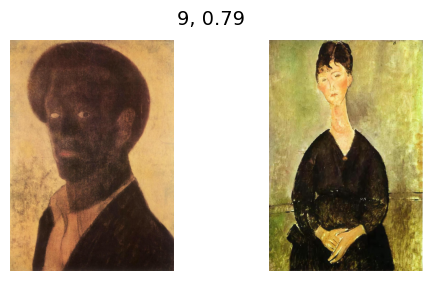

In [ ]:

s1 = style_vec_mps_safe(samples[0]['image'], layers=(-4, -2, -1), use_adain=False)
s2 = style_vec_mps_safe(samples[1]['image'], layers=(-4, -2, -1), use_adain=False)
cos_res = cosine(s1, s2)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
fig.suptitle(f"{style}, {cos_res:.2f}", fontsize=14)
for ax, sample in zip(axes, samples):
    ax.imshow(sample["image"])
    #ax.set_title(f"{sample['genre']}, {sample['artist']}")
    ax.axis("off")
plt.show()